In [64]:
# Importing relevant librairies
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import torch
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
# 0. Access some historical IMDB data files from the shared drive: 
# https://drive.google.com/drive/folders/1dl6nw0HO9XVrT8dSBJHHn3mDW9EWQpXS?usp=sharing
# 1. Read the files 'title.basics.tsv.gz', 'title.akas.tsv.gz' and 'title.ratings.tsv.gz' 
# into three separate dataframes using the read_csv method in Pandas.  

df_basics = pd.read_csv('title.basics.tsv.gz', compression='gzip', header=0, sep='\t', low_memory=False)
df_akas = pd.read_csv('title.akas.tsv.gz', compression='gzip', header=0, sep='\t', low_memory=False)
df_ratings = pd.read_csv('title.ratings.tsv.gz', compression='gzip', header=0, sep='\t', low_memory=False)

In [66]:
# Understanding the dataset. Also looked up: https://www.imdb.com/interfaces/ 

df_basics.info()
df_akas.info()
df_ratings.info()

# Noticed that 'tconst' column is named differently in df_akas!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5330276 entries, 0 to 5330275
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 366.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3423660 entries, 0 to 3423659
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   titleId          object
 1   ordering         int64 
 2   title            object
 3   region           object
 4   language         object
 5   types            object
 6   attributes       object
 7   isOriginalTitle  object
dtypes: int64(1), object(7)
memory usage: 209.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874203 entries, 0 to 874

In [67]:
# Understanding the dataset. Also looked up: https://www.imdb.com/interfaces/ 

print(df_basics)
print(df_akas)
print(df_ratings)

            tconst  titleType            primaryTitle           originalTitle  \
0        tt0000001      short              Carmencita              Carmencita   
1        tt0000002      short  Le clown et ses chiens  Le clown et ses chiens   
2        tt0000003      short          Pauvre Pierrot          Pauvre Pierrot   
3        tt0000004      short             Un bon bock             Un bon bock   
4        tt0000005      short        Blacksmith Scene        Blacksmith Scene   
...            ...        ...                     ...                     ...   
5330271  tt9120652  tvEpisode          Episode #18.93          Episode #18.93   
5330272  tt9120654  tvEpisode          Episode #18.95          Episode #18.95   
5330273  tt9120656      short            Upon Arrival            Upon Arrival   
5330274  tt9120782  videoGame    UEFA Euro 96 England    UEFA Euro 96 England   
5330275  tt9120906  tvEpisode         Episode #18.161         Episode #18.161   

         isAdult startYear 

In [68]:
# 2. Drop duplicates in all the dataframes, if there are any. 

df_basics.drop_duplicates()
df_akas.drop_duplicates()
df_ratings.drop_duplicates()

# No duplicates found!

,tconst,averageRating,numVotes
0,tt0000001,5.8,1422
1,tt0000002,6.4,168
2,tt0000003,6.6,1015
3,tt0000004,6.4,100
4,tt0000005,6.2,1713
...,...,...,...
874198,tt9100972,7.0,5
874199,tt9104810,7.0,7
874200,tt9106766,7.6,5
874201,tt9107292,8.4,10


In [69]:
# 3. Using the Pandas 'merge' method, combine all three dataframes using the Title ID (titleID or tconst) 
# to perform the merge and save it into a new dataframe. 

# Renaming df_akas's column entitled 'titleId' to 'tconst' for easier merge with title ID later
df_akas = df_akas.rename(columns={'titleId': 'tconst'})

# Placing all 3 dataframes in one list
df_list = [df_basics, df_akas, df_ratings]

In [70]:
# 3.1 How many lines does the resulting dataframe have if you use an inner merge or outer  
# merge? Make sure you understand the difference. 

df_merged_inner = reduce(lambda left, right: pd.merge(left, right, on=['tconst'],
                                                      how='inner'),
                         df_list).fillna('void')

print('Number of rows for an inner merge: ', df_merged_inner.shape[0])

df_merged_outer = reduce(lambda left, right: pd.merge(left, right, on=['tconst'],
                                                      how='outer'),
                         df_list).fillna('void')

print('Number of rows for an outer merge: ', df_merged_outer.shape[0])

print('Difference in number of rows: ', df_merged_outer.shape[0] - df_merged_inner.shape[0])

Number of rows for an inner merge:  1686547
Number of rows for an outer merge:  6740089
Difference in number of rows:  5053542


In [71]:
# The inner merge has a smaller number of rows since it only selects the similar rows across all three databases. 
# Whereas the outer merge naturally has a higher number of rows given that it returns all the rows across all
# three databases, and matches similar rows wherever possible.

In [72]:
# 3.2 Using the unique() method, compute how many different 'titleTypes' there are 
#print((df_merged_inner['titleType']))

print("Unique 'titleTypes' in an inner merge: ", pd.unique(df_merged_inner['titleType']))
print("Unique 'titleTypes' in an outer merge: ", pd.unique(df_merged_outer['titleType']))
no_title_types_inner = len(pd.unique(df_merged_inner['titleType']))
no_title_types_outer = len(pd.unique(df_merged_outer['titleType']))
print('Number of unique title types using inner merge: ', no_title_types_inner)
print('Number of unique title types using outer merge: ', no_title_types_outer)

# print('Number of unique title types per category, using inner merge: ', df_merged_inner['titleType'].value_counts())
# print('Number of unique title types per category, using outer merge: ', df_merged_outer['titleType'].value_counts())

Unique 'titleTypes' in an inner merge:  ['short' 'movie' 'tvMovie' 'tvSeries' 'tvEpisode' 'tvShort' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame']
Unique 'titleTypes' in an outer merge:  ['short' 'movie' 'tvMovie' 'tvSeries' 'tvEpisode' 'tvShort' 'tvMiniSeries'
 'tvSpecial' 'video' 'videoGame' 'void']
Number of unique title types using inner merge:  10
Number of unique title types using outer merge:  11


In [73]:
# 4. Make a new dataframe from step 3 by selecting only rows corresponding to English-language films ('en') 
# OR US-region films ('US') AND only those that are movies (using the 'titleType' column). Put the resulting 
# data into a new dataframe; call it df_new. 

df_new = df_merged_outer.loc[(df_merged_outer['titleType'] == 'movie') &
                             ((df_merged_outer['language'] == 'en') | (df_merged_outer['region'] == 'US'))]

# Double checking df_merged_outer['titleType'] is only movies, and only English-language or US-region specific
print('Are there only movies present: ', (df_new['titleType'] == 'movie').all())
print('Are there only English-language or US-region movies present: ', \
      ((df_new['language'] == 'en') | (df_new['region'] == 'US')).all())

Are there only movies present:  True
Are there only English-language or US-region movies present:  True


In [74]:
# 5. Add a new column to df_new with column title 'log10Votes' which gives the Log_10 number of the 'numVotes' column. 

# Ignoring rows where no numVotes are present
df_new = df_new[df_new['numVotes'] != 'void']

# Converting df_new['numVotes'] to float 
df_new['numVotes'] = df_new['numVotes'].astype(float)

df_new['log10Votes'] = np.log10(df_new['numVotes'])

df_new

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,ordering,title,region,language,types,attributes,isOriginalTitle,averageRating,numVotes,log10Votes
51,tt0000009,movie,Miss Jerry,Miss Jerry,0.0,1894,\N,45,Romance,3.0,Miss Jerry,US,\N,\N,\N,0,5.5,70.0,1.845098
576,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0.0,1897,\N,20,"Documentary,News,Sport",1.0,The Corbett-Fitzsimmons Fight,US,\N,\N,\N,0,5.2,266.0,2.424882
1840,tt0000630,movie,Hamlet,Amleto,0.0,1908,\N,\N,Drama,4.0,Hamlet,US,\N,\N,\N,0,3.1,10.0,1.000000
1950,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0.0,1908,\N,120,"Adventure,Fantasy",1.0,The Fairylogue and Radio-Plays,US,\N,\N,\N,0,5.9,26.0,1.414973
2370,tt0000886,movie,"Hamlet, Prince of Denmark",Hamlet,0.0,1910,\N,\N,Drama,2.0,"Hamlet, Prince of Denmark",US,\N,\N,\N,0,5.2,16.0,1.204120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6688235,tt9020894,movie,Temporary Difficulties,Vremennye trudnosti,0.0,2018,\N,86,Drama,4.0,Temporary Difficulties,US,\N,imdbDisplay,\N,0,4.5,20.0,1.301030
6705069,tt9056646,movie,Bearer,Dar Vajhe Hamel,0.0,2018,\N,90,Drama,3.0,Bearer,XWW,en,imdbDisplay,\N,0,7.0,9.0,0.954243
6706727,tt9060058,movie,Tuulte tahutud maa,Tuulte tahutud maa,0.0,2018,\N,63,Documentary,3.0,The Wind Sculpted Land,XWW,en,alternative,\N,0,8.1,17.0,1.230449
6717245,tt9081472,movie,Aickarakkonathe Bhishaguaranmaar,Aickarakkonathe Bhishaguaranmaar,0.0,2018,\N,144,Drama,2.0,Physicians of Aickarakkonam,IN,en,\N,literal English title,0,9.1,213.0,2.328380


In [75]:
# 6. Lower the case of all text in the 'genres' column. 

df_new['genres'] = df_new['genres'].str.lower()

# Double checking
print(df_new['genres'])

51                        romance
576        documentary,news,sport
1840                        drama
1950            adventure,fantasy
2370                        drama
                    ...          
6688235                     drama
6705069                     drama
6706727               documentary
6717245                     drama
6717290                    comedy
Name: genres, Length: 160034, dtype: object


In [76]:
# 6. Using Groupby (or other technique) group all data by 'genres' and display the top 10 highest genres by:

# 6.1 mean number of log10Votes

df_new_grouped_mean_1 = df_new.groupby(['genres'], as_index=False).log10Votes.mean()
df_new_grouped_mean_1.sort_values(by = 'log10Votes', ascending=False).head(10)

,genres,log10Votes
123,"action,fantasy,war",5.405722
112,"action,family,romance",4.801753
433,"animation,drama,war",4.396304
949,"family,music,musical",4.396252
824,"documentary,sport,thriller",4.386731
22,"action,adventure,sci-fi",4.373261
1028,"horror,musical,sci-fi",4.340484
529,"biography,fantasy,horror",4.271842
379,"adventure,sci-fi,thriller",4.180897
318,"adventure,drama,sci-fi",4.123983


In [77]:
# 6.2 mean averageRating

df_new_grouped_mean_2 = df_new.groupby(['genres'], as_index=False).averageRating.mean()
df_new_grouped_mean_2.sort_values(by = 'averageRating', ascending=False).head(10)

,genres,averageRating
795,"documentary,history,western",9.300000
1016,"history,sport",9.200000
815,"documentary,news,reality-tv",8.800000
408,"animation,crime,documentary",8.525000
531,"biography,history,music",8.500000
307,"adventure,documentary,western",8.433333
766,"documentary,drama,thriller",8.433333
653,"comedy,mystery,sport",8.400000
88,"action,documentary,fantasy",8.300000
506,"biography,documentary,talk-show",8.300000


<AxesSubplot:xlabel='averageRating', ylabel='log10Votes'>

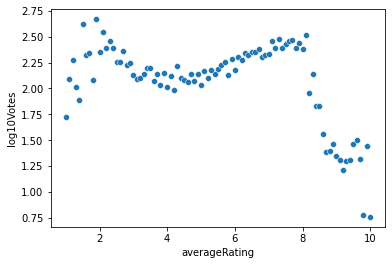

In [78]:
# 7. Using ‘groupby’ group all data by averageRating and make a scatter plot of averageRating vs log10Votes. 

df_new_grouped_2 = df_new.groupby(['averageRating'], as_index=False).log10Votes.mean()

sns.scatterplot(x='averageRating', y='log10Votes', data=df_new_grouped_2)

In [79]:
# 8. Perform linear regression on your data (averageRating vs log10Votes) created in the previous step in three 
# different ways:
#    8.1 Using sklearn 
#    8.2 Using scipy 
#    8.3 Using pytorch 

# Data cleaning and wrangling
# Ignoring rows where no averageRating are present
#df_new = df_new[df_new['averageRating'] != 'void']

# Converting df_new['averageRating'] to float 
#df_new['averageRating'] = df_new['averageRating'].astype(float)    

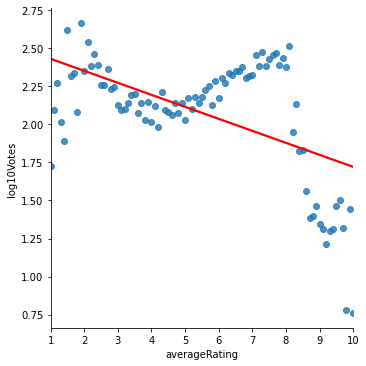

In [80]:
# Understanding the initial relationship

from scipy import stats

sns.lmplot(x ='averageRating', y ='log10Votes', data = df_new_grouped_2, order = 1, ci = None, line_kws={'color': 'red'})

In [81]:
# 8.1 Using sklearn 

x = np.array(df_new_grouped_2['averageRating']).reshape(-1, 1)
y = np.array(df_new_grouped_2['log10Votes']).reshape(-1, 1)

#print(x, y)

skl_lreg = LinearRegression().fit(x, y)

# # Coefficient of determination of the prediction
# print('Score: ', skl_lreg.score(x, y))

print('Coefficient: ' + str(skl_lreg.coef_)[2:-2])
print('Intercept: '+ str(skl_lreg.intercept_)[1:-1] )

Coefficient: -0.07894134
Intercept: 2.51055314


In [82]:
# 8.2 Using scipy 

x = df_new_grouped_2['averageRating'] 
y = df_new_grouped_2['log10Votes'] 

#print(x, y)

sci_lreg = linregress(x, y)

print('Coefficient: ', sci_lreg.slope)
print('Intercept: ', sci_lreg.intercept)

Coefficient:  -0.07894133621603047
Intercept:  2.5105531440478197


In [86]:
# 8.3 Using pytorch 

x = np.array(df_new_grouped_2['averageRating']).reshape(-1, 1)
y = np.array(df_new_grouped_2['log10Votes']).reshape(-1, 1)

x_data = Variable(torch.Tensor(x))
y_data = Variable(torch.Tensor(y))

class LinearRegressionModel(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
      super(LinearRegressionModel, self).__init__()
      self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # forward pass function takes x as input to predict predict y
        y_pred = self.linear(x)
        return y_pred

input_dim = 1
output_dim = 1
    
pyT_model = LinearRegressionModel(1, 1) # where (Input size = 1, Output size = 1)

# Criterion used to calculate the loss function between y_data and y_pred 
# in order to update weights for the best model selection in next step during loop
criterion = torch.nn.MSELoss() # using mean square error (most commonly used)

[w, b] = model.parameters()
def get_param_values():
   return w.data[0][0], b.data[0]

# optimizer to update hyperparameters, where lr=0.01 defines learning rates for the parameter updates.
optimizer = torch.optim.SGD(pyT_model.parameters(), lr = 0.01) # using stochastic gradient descent

no_of_epochs = 1000

for epoch in range(no_of_epochs):
 
    # Forward pass
    pred_y = pyT_model.forward(x_data)
 
    # Compute loss
    loss = criterion(pred_y, y_data)
 
    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print('epoch {}, loss {}'.format(epoch, loss.item()))
    
print('Coefficient: ', float(w))
print('Intercept: ', float(b))

Coefficient:  -0.07893584668636322
Intercept:  2.510516405105591


In [84]:
# Ensure that you get the same result in each case (or explain why the results are different). You will need to 
# install the corresponding packages. If you wanted to build a better regression model what would you do?  

# Same coefficient (gradient) and intercept values (when comparing to till the 4th decimal) using sklearn, scipy, and pytorch methods of linear regression. 

# Build better regression model by:
# - Implementing better data cleaning (to remove outliers).
# - The initial analysis between of averageRating vs log10Votes showed that a linear relationship was not globally present. 
#   A better method would have been to separate the dataset into three parts, where a better linear relationship would be present.